<a href="https://colab.research.google.com/github/Hahaitsriya/SkinCancerDetection/blob/main/SkinCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install opendatasets

In [4]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000/data'
od.download('https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: riyashakyas
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000


100%|██████████| 5.20G/5.20G [00:37<00:00, 150MB/s]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [6]:
df = pd.read_csv("/content/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
df.nunique()

,0
lesion_id,7470
image_id,10015
dx,7
dx_type,4
age,18
sex,3
localization,15


In [8]:
def load_image(image_path):
    return np.array(Image.open(image_path))

In [9]:
df.shape

(10015, 7)

In [10]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [11]:
dx_mapping = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['dx'] = df['dx'].map(dx_mapping)

In [12]:
df['dx'].value_counts()

,count
dx,
Melanocytic nevi,6705
Melanoma,1113
Benign keratosis-like lesions,1099
Basal cell carcinoma,514
Actinic keratoses,327
Vascular lesions,142
Dermatofibroma,115


In [13]:
categorical_columns = ['lesion_id', 'image_id', 'dx', 'dx_type', 'sex', 'localization']
numerical_columns = ['age']

In [14]:
for column in categorical_columns:
    df['localization'].value_counts()

df['localization'].value_counts()

,count
localization,
back,2192
lower extremity,2077
trunk,1404
upper extremity,1118
abdomen,1022
face,745
chest,407
foot,319
unknown,234


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [16]:
print(df.isnull().sum())


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


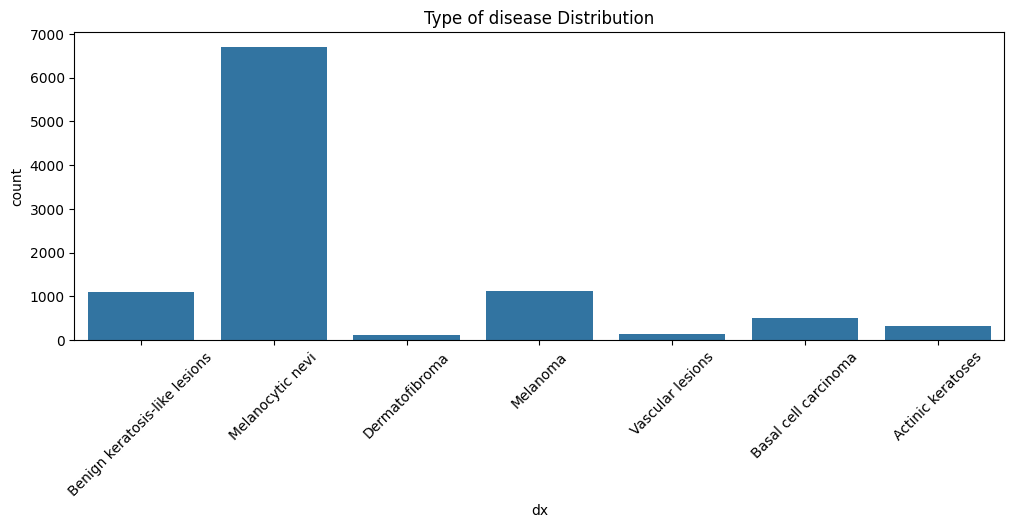

In [17]:
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='dx')
plt.title('Type of disease Distribution')
plt.xticks(rotation=45)
plt.show()

In [18]:
for column in categorical_columns:
    df['sex'].value_counts()

df['sex'].value_counts()

,count
sex,
male,5406
female,4552
unknown,57


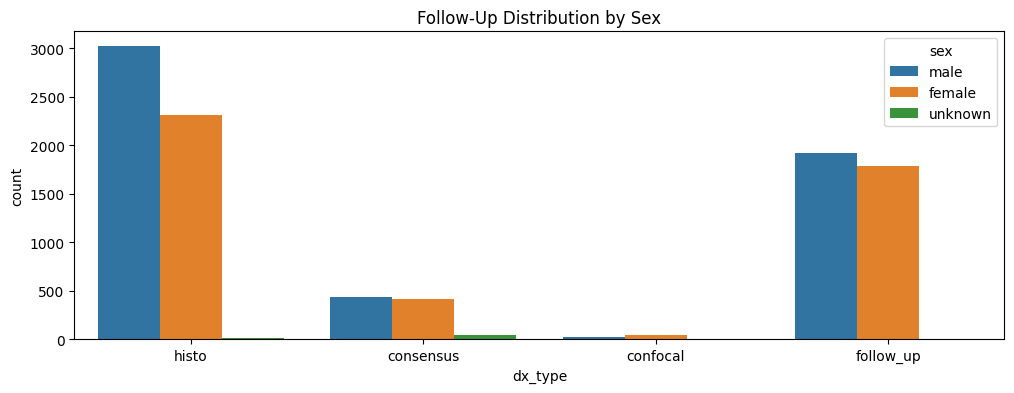

In [19]:
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='dx_type', hue='sex')
plt.title('Follow-Up Distribution by Sex')
plt.show()

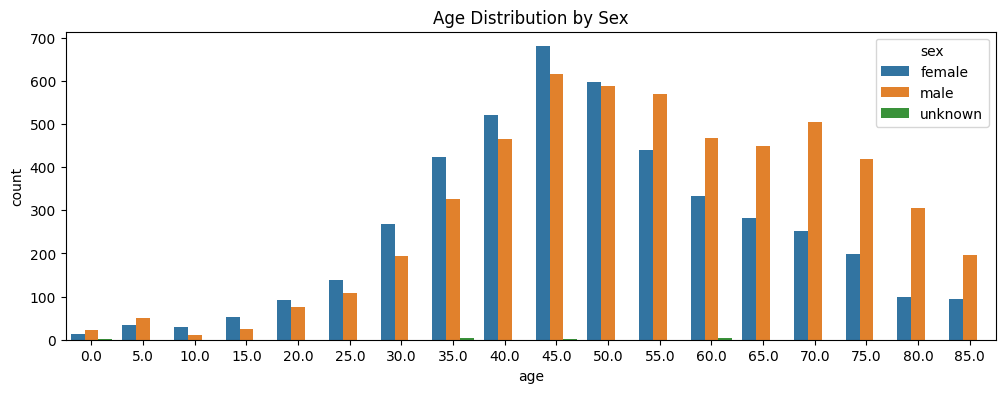

In [20]:
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='age', hue='sex')
plt.title('Age Distribution by Sex')
plt.show()

Data Preprocessing

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [22]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,Benign keratosis-like lesions,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Benign keratosis-like lesions,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Benign keratosis-like lesions,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Benign keratosis-like lesions,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Benign keratosis-like lesions,histo,75.0,male,ear


In [23]:
df = df.drop_duplicates()

In [24]:
df.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


In [25]:
median_age = df['age'].median()
df['age'] = df['age'].fillna(median_age)

In [26]:
df = df.rename(columns={
    'lesion_id': 'Lesion_Id',
    'image_id': 'Image_Id',
    'dx': 'Diagnosis',
    'dx_type': 'Confirmation_Method',
    'age': 'Age',
    'sex': 'Sex',
    'localization': 'Region_Of_Disease'
})

In [27]:
df.head()

,Lesion_Id,Image_Id,Diagnosis,Confirmation_Method,Age,Sex,Region_Of_Disease
0,HAM_0000118,ISIC_0027419,Benign keratosis-like lesions,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Benign keratosis-like lesions,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Benign keratosis-like lesions,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Benign keratosis-like lesions,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Benign keratosis-like lesions,histo,75.0,male,ear


In [28]:
df['Age'] = df['Age'].astype(int)

In [29]:
image_path1='/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_path2='/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

In [30]:
final_image_dataset = '/content/skin-cancer-mnist-ham10000'

In [31]:
import os
import shutil
# Create the destination folder if it doesn't exist
if not os.path.exists(final_image_dataset):
    os.makedirs(final_image_dataset)

# Iterate through files in folder 1 and copy them to the destination folder
for filename in os.listdir(image_path1):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        shutil.copy(os.path.join(image_path1, filename), final_image_dataset)

# Iterate through files in folder 2 and copy them to the destination folder
for filename in os.listdir(image_path2):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        shutil.copy(os.path.join(image_path2, filename), final_image_dataset)

In [32]:
df['Image_path'] = df['Image_Id'].apply(lambda x: os.path.join(final_image_dataset, f"{x}.jpg"))

In [33]:
df

,Lesion_Id,Image_Id,Diagnosis,Confirmation_Method,Age,Sex,Region_Of_Disease,Image_path
0,HAM_0000118,ISIC_0027419,Benign keratosis-like lesions,histo,80,male,scalp,/content/skin-cancer-mnist-ham10000/ISIC_00274...
1,HAM_0000118,ISIC_0025030,Benign keratosis-like lesions,histo,80,male,scalp,/content/skin-cancer-mnist-ham10000/ISIC_00250...
2,HAM_0002730,ISIC_0026769,Benign keratosis-like lesions,histo,80,male,scalp,/content/skin-cancer-mnist-ham10000/ISIC_00267...
3,HAM_0002730,ISIC_0025661,Benign keratosis-like lesions,histo,80,male,scalp,/content/skin-cancer-mnist-ham10000/ISIC_00256...
4,HAM_0001466,ISIC_0031633,Benign keratosis-like lesions,histo,75,male,ear,/content/skin-cancer-mnist-ham10000/ISIC_00316...
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,Actinic keratoses,histo,40,male,abdomen,/content/skin-cancer-mnist-ham10000/ISIC_00330...
10011,HAM_0002867,ISIC_0033550,Actinic keratoses,histo,40,male,abdomen,/content/skin-cancer-mnist-ham10000/ISIC_00335...
10012,HAM_0002867,ISIC_0033536,Actinic keratoses,histo,40,male,abdomen,/content/skin-cancer-mnist-ham10000/ISIC_00335...
10013,HAM_0000239,ISIC_0032854,Actinic keratoses,histo,80,male,face,/content/skin-cancer-mnist-ham10000/ISIC_00328...


In [34]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
df['Updated_Diagnosis_Label'] = label_encoder.fit_transform(df['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 'Benign keratosis-like lesions': 2, 'Dermatofibroma': 3, 'Melanocytic nevi': 4, 'Melanoma': 5, 'Vascular lesions': 6}


In [35]:
df.head()

,Lesion_Id,Image_Id,Diagnosis,Confirmation_Method,Age,Sex,Region_Of_Disease,Image_path,Updated_Diagnosis_Label
0,HAM_0000118,ISIC_0027419,Benign keratosis-like lesions,histo,80,male,scalp,/content/skin-cancer-mnist-ham10000/ISIC_00274...,2
1,HAM_0000118,ISIC_0025030,Benign keratosis-like lesions,histo,80,male,scalp,/content/skin-cancer-mnist-ham10000/ISIC_00250...,2
2,HAM_0002730,ISIC_0026769,Benign keratosis-like lesions,histo,80,male,scalp,/content/skin-cancer-mnist-ham10000/ISIC_00267...,2
3,HAM_0002730,ISIC_0025661,Benign keratosis-like lesions,histo,80,male,scalp,/content/skin-cancer-mnist-ham10000/ISIC_00256...,2
4,HAM_0001466,ISIC_0031633,Benign keratosis-like lesions,histo,75,male,ear,/content/skin-cancer-mnist-ham10000/ISIC_00316...,2


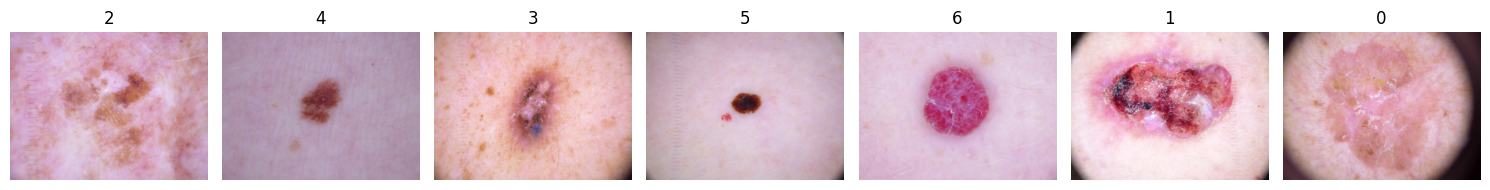

In [37]:
for i in range(len(df)):
    if not os.path.isfile(df['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {df['Image_path'].iloc[i]}")

# Get one image per class
class_images = df.drop_duplicates(subset='Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Updated_Diagnosis_Label'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

In [38]:
pip install imgaug opencv-python

In [39]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from skimage import io

In [40]:
import os
import pandas as pd
from skimage import io
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

# Define your augmentation pipeline
aug_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip with probability 0.5
    iaa.Affine(rotate=(-10, 10)),  # Random rotation within -10 to 10 degrees
    iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}),  # Random scaling within 90% to 110%
    iaa.Crop(percent=(0, 0.2)),# Crop images from each side by 0% to 20% of their height/width
    iaa.Affine(shear=(-5, 5)),  # Random shear within -5 to 5 degrees
    iaa.GaussianBlur(sigma=(0, 0.5)),  # Gaussian blur with a small sigma
    iaa.AdditiveGaussianNoise(scale=(0, 0.01*255)),  # Small additive Gaussian noise
    iaa.ContrastNormalization((0.9, 1.1)),
    iaa.CLAHE(clip_limit=(1, 2))  # Apply CLAHE with a moderate clip limit
])

# Directory to save augmented images
augmented_images_dir = '/path/to/augmented_images'
os.makedirs(augmented_images_dir, exist_ok=True)

# Get the class counts
class_counts = df['Diagnosis'].value_counts()
max_count = class_counts.max()

# Create an empty list to hold the balanced samples
balanced_samples = []

# Oversample each class with augmentation to match the class with the maximum count
for label in class_counts.index:
    class_subset = df[df['Diagnosis'] == label]

    if len(class_subset) < max_count:
        n_augmentations = max_count - len(class_subset)
        augmented_samples = []
        for i in range(n_augmentations):
          sample = class_subset.sample(n=1, random_state=42).iloc[0]
          img_path = sample['Image_path']
          img = io.imread(img_path)
          augmented_image = aug_pipeline(image=img)

            # Save the augmented image
          augmented_image_path = os.path.join(augmented_images_dir, f'{label}_augmented_{i}.jpg')
          io.imsave(augmented_image_path, augmented_image)

            # Store the augmented image and update the image path
          augmented_sample = sample.copy()
          augmented_sample['Image_path'] = augmented_image_path
          augmented_samples.append(augmented_sample)

        augmented_df = pd.DataFrame(augmented_samples)
        class_oversampled = pd.concat([class_subset, augmented_df], ignore_index=True)
    else:
        class_oversampled = class_subset

    balanced_samples.append(class_oversampled)

# Combine all oversampled classes into a single DataFrame
balanced_dataset = pd.concat(balanced_samples).reset_index(drop=True)

print("Dataset balanced successfully!")

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Dataset balanced successfully!


In [41]:
df = balanced_dataset
df.head()

,Lesion_Id,Image_Id,Diagnosis,Confirmation_Method,Age,Sex,Region_Of_Disease,Image_path,Updated_Diagnosis_Label
0,HAM_0001751,ISIC_0024698,Melanocytic nevi,consensus,70,male,face,/content/skin-cancer-mnist-ham10000/ISIC_00246...,4
1,HAM_0000559,ISIC_0024693,Melanocytic nevi,follow_up,45,female,upper extremity,/content/skin-cancer-mnist-ham10000/ISIC_00246...,4
2,HAM_0004932,ISIC_0032212,Melanocytic nevi,follow_up,45,female,foot,/content/skin-cancer-mnist-ham10000/ISIC_00322...,4
3,HAM_0004516,ISIC_0025775,Melanocytic nevi,follow_up,45,female,neck,/content/skin-cancer-mnist-ham10000/ISIC_00257...,4
4,HAM_0006510,ISIC_0029828,Melanocytic nevi,follow_up,55,female,lower extremity,/content/skin-cancer-mnist-ham10000/ISIC_00298...,4


In [42]:
X = df.drop(columns=['Updated_Diagnosis_Label'])
y = df['Updated_Diagnosis_Label']

# Display the shape of X and y
print("Shape of features (X):", X.shape)
print("Shape of target variable (y):", y.shape)

Shape of features (X): (46935, 8)
Shape of target variable (y): (46935,)


In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=X_val,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical',
    shuffle=False
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical',
    shuffle=False
)

Found 30038 validated image filenames belonging to 7 classes.
Found 7510 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.


In [45]:
from tensorflow.keras.applications import DenseNet121,InceptionV3,Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

# Load ResNet50 pre-trained on ImageNet without the top layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

83683744/83683744 [==============================] - 0s 0us/step


In [46]:
model = Model(inputs=base_model.input, outputs=predictions)


In [47]:
for layer in base_model.layers:
    layer.trainable = False

In [48]:
from keras.optimizers import Adam
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
            metrics=['accuracy'])

In [49]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# Define callbacks
checkpoint = ModelCheckpoint(filepath='model_weights.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [50]:
class_counts = df['Updated_Diagnosis_Label'].value_counts().to_dict()
total_samples = sum(class_counts.values())
class_weights = {i: total_samples/count for i, count in enumerate(class_counts.values())}

print("Class weights:", class_weights)

Class weights: {0: 7.0, 1: 7.0, 2: 7.0, 3: 7.0, 4: 7.0, 5: 7.0, 6: 7.0}


In [51]:
class_weights_dict = dict(enumerate(class_weights))

In [52]:
history=model.fit(
    train_generator,
    epochs=10,
    batch_size=100,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/10
301/301 [==============================] - 638s 2s/step - loss: 0.2506 - accuracy: 0.9212 - val_loss: 0.2098 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 2/10
301/301 [==============================] - 683s 2s/step - loss: 0.1871 - accuracy: 0.9363 - val_loss: 0.1803 - val_accuracy: 0.9361 - lr: 0.0010
Epoch 3/10
301/301 [==============================] - 623s 2s/step - loss: 0.1697 - accuracy: 0.9410 - val_loss: 0.1680 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 4/10
301/301 [==============================] - 605s 2s/step - loss: 0.1655 - accuracy: 0.9422 - val_loss: 0.1739 - val_accuracy: 0.9397 - lr: 0.0010
Epoch 5/10
301/301 [==============================] - 600s 2s/step - loss: 0.1585 - accuracy: 0.9440 - val_loss: 0.1663 - val_accuracy: 0.9406 - lr: 0.0010
Epoch 6/10
301/301 [==============================] - 599s 2s/step - loss: 0.1567 - accuracy: 0.9436 - val_loss: 0.1705 - val_accuracy: 0.9399 - lr: 0.0010
Epoch 7/10
301/301 [==============================] - 595s 2s/st